# 0. Imports & functions

In [1]:
import sys

sys.path.append("../")

In [2]:
from src.common_functions import *
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 1. Load data, prep & train test split

In [3]:
df = pd.read_csv("../datasets/churn/telco_churn.csv")
df = df.rename(columns=dict(
    zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,...,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [4]:
y = "customer_status"

# some generic cleaning
df["avg_monthly_long_distance_charges"] = df["avg_monthly_long_distance_charges"].fillna(
    0.0)
df["multiple_lines"] = df["multiple_lines"].fillna('no phone service')
df["avg_monthly_gb_download"] = df["avg_monthly_gb_download"].fillna(0)
no_internet = ['internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
               'streaming_movies', 'streaming_music', 'unlimited_data']
df[no_internet] = df[no_internet].fillna('no internet service')
COLUMNS_TO_DROP = ["customer_id", "churn_category",
                   "churn_reason", "longitude", "latitude", "city"]
df = df[df[y] != "Joined"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

# 2. Model selection

## Logistic Regression

In [5]:
df[y].value_counts()/len(df)

customer_status
Stayed     0.716345
Churned    0.283655
Name: count, dtype: float64

In [6]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = "logistic"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name=MODEL_NAME, param_grid=param_grid, verbose=1)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


KeyboardInterrupt: 

In [ ]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
29,0.5,0.7,15,1,l2,0.874280,0.007231
113,0.5,0.7,15,10,l2,0.874931,0.007680
197,0.5,0.7,15,100,l2,0.874194,0.007516
281,0.5,0.7,15,1000,l2,0.874180,0.007730
33,0.5,0.7,20,1,l2,0.875949,0.006836
...,...,...,...,...,...,...,...
330,0.7,1.0,50,1000,l2,0.912794,0.006626
82,0.7,1.0,65,1,l2,0.912437,0.007346
166,0.7,1.0,65,10,l2,0.912567,0.006877
250,0.7,1.0,65,100,l2,0.912757,0.005350


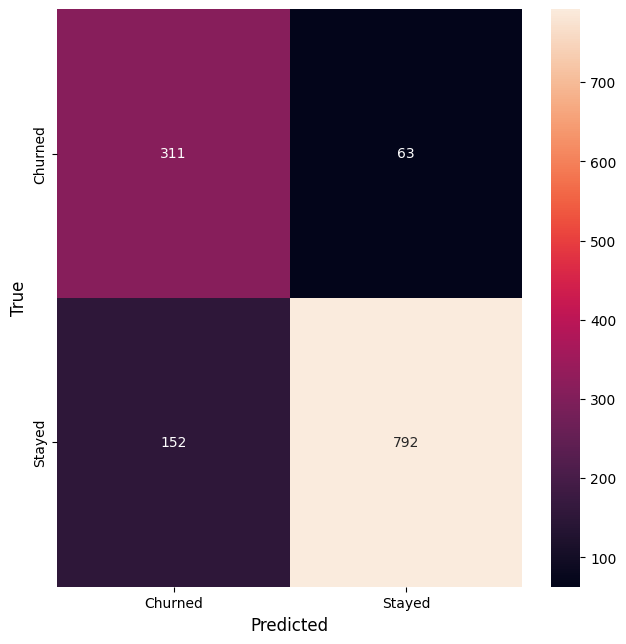

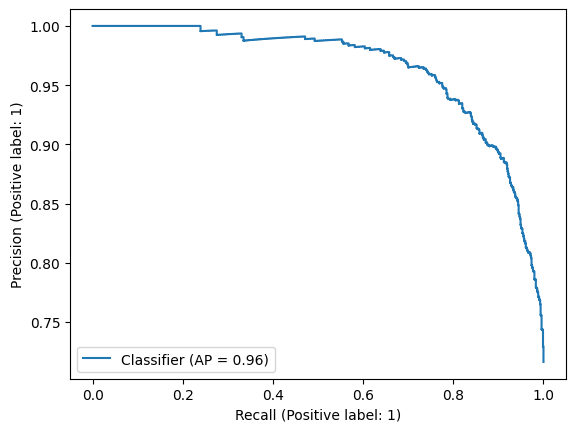

In [ ]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y)

In [ ]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized=True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

SyntaxError: keyword argument repeated: model_name (2399401710.py, line 18)

In [13]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

KeyError: 'logistic'

# 3. Cost-based evaluation

In [22]:
df['A'] = df['monthlycharge']

# Step 2: Define a function to calculate the instance-dependent cost


def instance_dependent_cost(predicted_label, true_label, A):
    if true_label == 1 and predicted_label == 1:  # True Positive (TP)
        return 0
    elif true_label == 0 and predicted_label == 1:  # False Positive (FP)
        return 2 * A
    elif true_label == 0 and predicted_label == 0:  # True Negative (TN)0
        return 0
    elif true_label == 1 and predicted_label == 0:  # False Negative (FN)
        return 12 * A


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
df['instance_cost'] = df.apply(lambda row: instance_dependent_cost(
    row['predicted_labels'], row['true_labels'], row['A']), axis=1)

# Print the DataFrame with the instance-dependent cost matrix
print(df[['monthlycharge', 'predicted_labels', 'true_labels', 'instance_cost']])

KeyError: 'predicted_labels'

In [258]:
X_train = np.array([[...], [...], ...])  # Replace '...' with your actual features

# Example binary target labels
y_train = np.array([0, 1, 1, 0])  # Replace with your actual target labels

# Create a list to store instance-dependent predicted probabilities (X values)
instance_probs = []

# Train a logistic regression model for each instance and get the predicted probabilities
for i in range(len(X_train)):
    # Select the i-th instance as a single-sample training set
    X_single_instance = X_train[i].reshape(1, -1)
    y_single_instance = y_train[i]

    # Create a logistic regression model
    model = LogisticRegression()

    # Fit the model to the single-instance data
    model.fit(X_single_instance, [y_single_instance])

    # Predict the probability for class 1 (positive class)
    prob_class_1 = model.predict_proba(X_single_instance)[:, 1]

    # Append the predicted probability to the list
    instance_probs.append(prob_class_1[0])

# Convert the list to a numpy array
X_predicted_probs = np.array(instance_probs)

# Now, X_predicted_probs contains the instance-dependent predicted probabilities (X values)
print("Instance-Dependent Predicted Probabilities (X):", X_predicted_probs)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [256]:
def cross_entropy_cost(hypothesis, y_true):
    # Ensure the hypothesis values are clipped to avoid taking the logarithm of zero
    epsilon = 1e-15
    hypothesis = np.clip(hypothesis, epsilon, 1 - epsilon)

    # Calculate the cross-entropy cost
    cost = -np.mean(y_true * np.log(hypothesis) + (1 - y_true) * np.log(1 - hypothesis))
    return cost




In [257]:
y_true = np.array([0, 1, 1, 0])
instance_costs = [cross_entropy_cost(X[i], y_true[i]) for i in range(len(X))]

IndexError: index 4 is out of bounds for axis 0 with size 4